In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import glob
import os
batch_size = 8
epochs = 20
test_size = 0.1
n = 60

In [10]:
import os
import numpy as np


path_data = r"C:\Users\jorri\GitHub\capstone-group-6\datasets"

postfix = ["0","_1000to1050","_1050to1400",  "_1400to2000", "_2000to3000", 
           "_3000to4000", "_4000to5000", "_5000to6000", "_6000to7000", "_7000to8000"]

k_all = []
h_all = []

for p in postfix:
    # Construct file names (with .txt)
    k_file = os.path.join(path_data, f"k_set{p}.txt")
    h_file = os.path.join(path_data, f"h_set{p}.txt")
    
    # Load the k file
    if os.path.exists(k_file):
        k_data = np.loadtxt(k_file)
        # Assuming each row is a 3600-long array, otherwise reshape
        if k_data.ndim == 1:  # single array
            k_all.append(k_data)
        else:  # multiple arrays
            k_all.extend(k_data)
    else:
        print(f"Warning: {k_file} not found.")
    
    # Load the h file
    if os.path.exists(h_file):
        h_data = np.loadtxt(h_file)
        if h_data.ndim == 1:
            h_all.append(h_data)
        else:
            h_all.extend(h_data)
    else:
        print(f"Warning: {h_file} not found.")
k_data = np.array(k_all).reshape(-1, 60, 60, 1)
h_data = np.array(h_all).reshape(-1, 60, 60, 1)
print(f"Total k grids loaded: {len(k_data)}")
print(f"Total h grids loaded: {len(h_data)}")


Total k grids loaded: 8000
Total h grids loaded: 8000


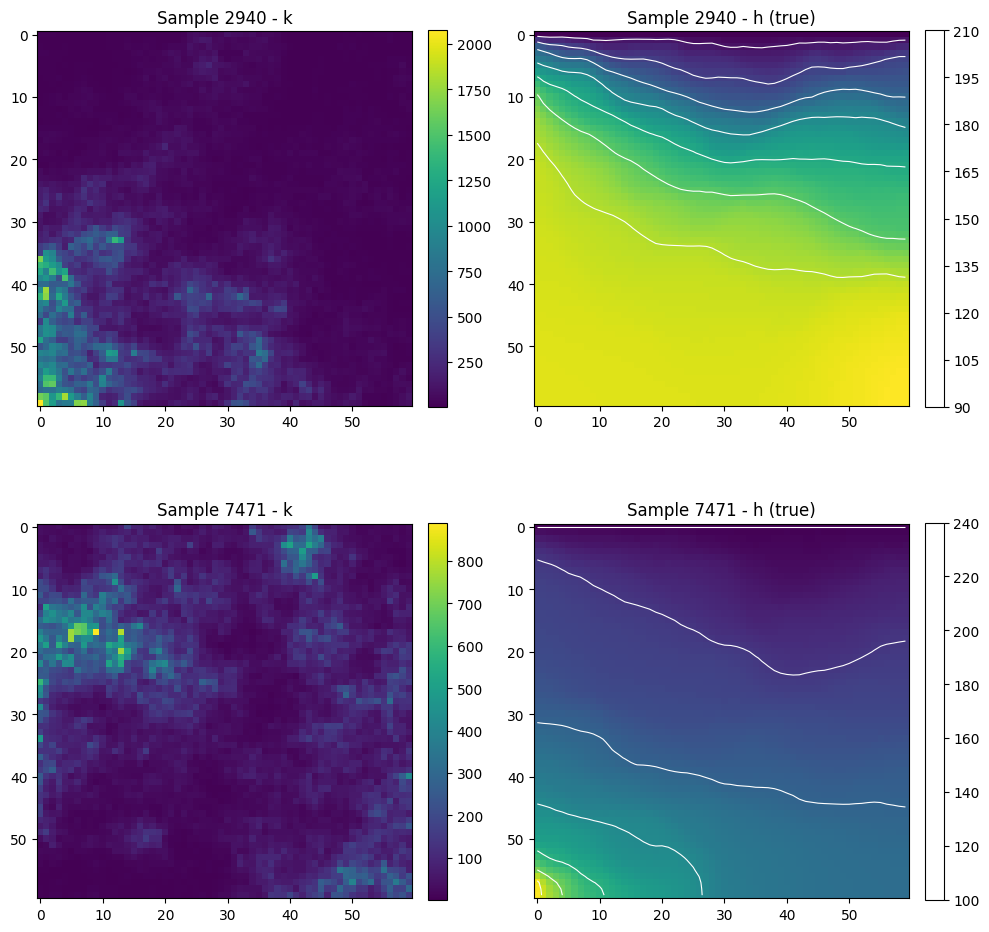

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Pick 2 random samples from the dataset
num_samples = 2
indices = np.random.choice(len(k_data), size=num_samples, replace=False)

plt.figure(figsize=(10, num_samples * 5))

for i, idx in enumerate(indices):
    k_sample = k_data[idx, :, :, 0]
    h_sample = h_data[idx, :, :, 0]

    # Plot k
    plt.subplot(num_samples, 2, i*2 + 1)
    plt.imshow(k_sample, cmap='viridis')
    plt.title(f"Sample {idx} - k")
    plt.colorbar(fraction=0.046, pad=0.04)

    # Plot h with contour
    plt.subplot(num_samples, 2, i*2 + 2)
    plt.imshow(h_sample, cmap='viridis')
    plt.contour(h_sample, colors='white', linewidths=0.8)
    plt.title(f"Sample {idx} - h (true)")
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [13]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x

    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = conv_block(p2, 64)
    c3 = layers.Dropout(0.3)(c3)

    # Decoder
    def up_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    u2 = up_block(c3, c2, 32)
    u1 = up_block(u2, c1, 16)

    outputs = layers.Conv2D(1, 1, activation='linear')(u1)
    model = models.Model(inputs, outputs)
    return model

# Build model
model = unet_model((n, n, 1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 60, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 60, 60,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 60, 60,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 60, 60,    │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 30, 30,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 15, 15,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 15,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 30, 30,    │      8,224 │ dropout[0][0]   

 Total params: 118,033 (461.07 KB)

 Trainable params: 117,393 (458.57 KB)

 Non-trainable params: 640 (2.50 KB)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    k_data, h_data, test_size=test_size, random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (7200, 60, 60, 1) (7200, 60, 60, 1)
Test shape: (800, 60, 60, 1) (800, 60, 60, 1)


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - loss: 270.0512 - mse: 270.0512 - val_loss: 211.7887 - val_mse: 211.7887 - learning_rate: 0.0010
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - loss: 267.1375 - mse: 267.1375 - val_loss: 205.6925 - val_mse: 205.6925 - learning_rate: 0.0010
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 265.7899 - mse: 265.7899 - val_loss: 328.0074 - val_mse: 328.0074 - learning_rate: 0.0010
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 248.7009 - mse: 248.7009 - val_loss: 216.8812 - val_mse: 216.8812 - learning_rate: 0.0010
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - loss: 244.5596 - mse: 244.5596 - val_loss: 252.4470 - val_mse: 252.4470 - learning_rate: 0.0010
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - loss: 241.9737 - mse: 241.9737 - val_loss: 351.6161 - val_mse: 351.6162 - learning_rate: 0.0010
Epoch 7/10
809/810 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 277.8365 - mse: 277.8365
Ep

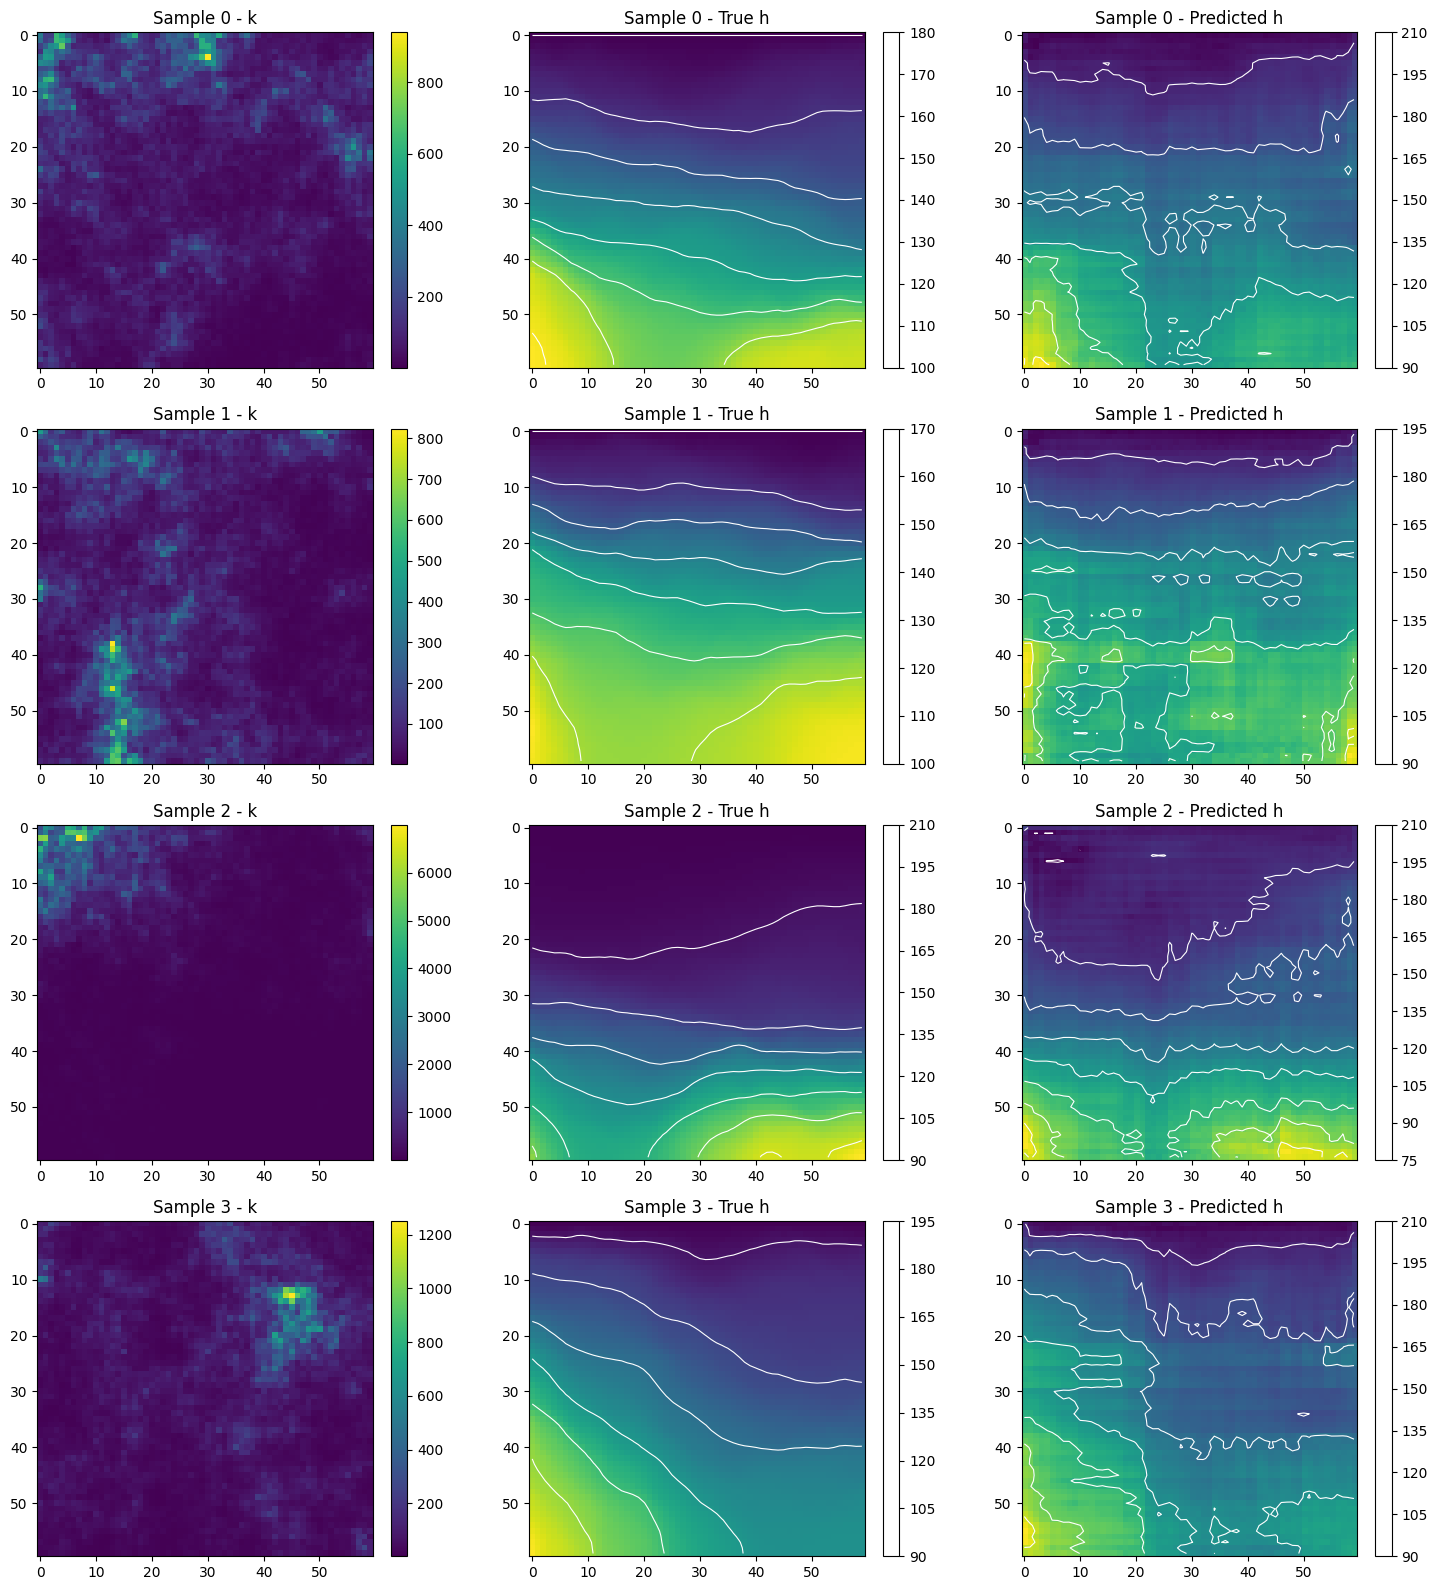

In [17]:
import matplotlib.pyplot as plt
import numpy as np

num_samples = 4
plt.figure(figsize=(15, num_samples * 4))

for i in range(num_samples):
    k_sample = X_test[i, :, :, 0]      # 2D grid
    h_true = y_test[i, :, :, 0]        # 2D grid
    h_pred = model.predict(X_test[i:i+1], verbose=0)[0, :, :, 0]  # 2D grid

    # Plot k
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.title(f"Sample {i} - k")
    plt.imshow(k_sample, cmap='viridis')
    plt.colorbar(fraction=0.046, pad=0.04)

    # Plot true h with contour
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.title(f"Sample {i} - True h")
    plt.imshow(h_true, cmap='viridis')
    plt.contour(h_true, colors='white', linewidths=0.8)  # contours
    plt.colorbar(fraction=0.046, pad=0.04)

    # Plot predicted h with contour
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.title(f"Sample {i} - Predicted h")
    plt.imshow(h_pred, cmap='viridis')
    plt.contour(h_pred, colors='white', linewidths=0.8)  # contours
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
